# Assignment 1

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

1. Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
2. Connecting such ADUs through support or attack relations.
3. Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.

In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

- A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
- A file containing details for each opinion article that has been annotated, including the full article content.
- Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Preparing the Data

Firstly, we must import the dataset into the notebook

In [1]:
import pandas as pd

# Importing the dataset
train = pd.read_excel('OpArticles_ADUs.xlsx')
test = pd.read_excel('OpArticles.xlsx')

train.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


Next, we should do some exploratory analysis:

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64
Value       0.483904
Fact        0.218778
Value(-)    0.173207
Value(+)    0.084274
Policy      0.039838
Name: label, dtype: float64
article_id    0
annotator     0
node          0
ranges        0
tokens        0
label         0
dtype: int64


<AxesSubplot:>

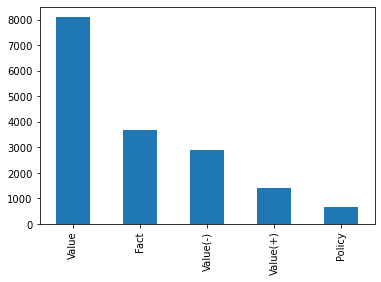

In [4]:
print(train['label'].value_counts())

print(train['label'].value_counts(normalize=True))

print(train.isna().sum())

train['label'].value_counts().plot(kind='bar')

## Cleanup and normalization

The next step is to cleanup our dataset and normalize some data

#### Removing non-alphabetic chars

Let's start by removing any non-alpha chars, using a regular expression. We'll create a separate corpus (a list of tokens), so that we leave the original dataset untouched.

#### Lowercasing

We can then apply lowercasing, so that words such as *Amazing*, *AMAZING* and *amazing* all have the same representation.

#### Removing stop words

Another common step which is sometimes applied is to remove any stop words (words that do not have domain semantics attached). We can use the stop words list provided in NLTK for English:

#### Stemming

Finally, we can apply stemming to further reduce the size of the vocabulary through normalization.

In [3]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = train
ps = PorterStemmer()
for i in range(0, train['tokens'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', train['tokens'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([ps.stem(w) for w in review.split() if not w in set(stopwords.words('portuguese'))])
    corpus['tokens'][i] = review

print(corpus)

<ipython-input-3-a26e55bf0bdf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['tokens'][i] = review


                     article_id annotator  node                        ranges  \
0      5d04a31b896a7fea069ef06f         A     0                [[2516, 2556]]   
1      5d04a31b896a7fea069ef06f         A     1                [[2568, 2806]]   
2      5d04a31b896a7fea069ef06f         A     3                [[3169, 3190]]   
3      5d04a31b896a7fea069ef06f         A     4                [[3198, 3285]]   
4      5d04a31b896a7fea069ef06f         A     6                [[4257, 4296]]   
...                         ...       ...   ...                           ...   
16738  5cf4b764896a7fea06032673         D    29  [[4980, 5041], [5074, 5279]]   
16739  5cf4b764896a7fea06032673         D    30                [[5293, 5340]]   
16740  5cf4b764896a7fea06032673         D    32                [[5053, 5072]]   
16741  5cf4b764896a7fea06032673         D    34                [[5549, 5643]]   
16742  5cf4b764896a7fea06032673         D    35                [[5488, 5537]]   

                           

## Obtaining Features

The next step is to obtain the features we will use to train our model.

For this, we will use TF-IDF with N-Grams, but firstly, we will divide our tokens from our label:

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = []
for sentence in corpus['tokens']:
    tokens.append(sentence)
    
vectorizer = TfidfVectorizer()
vectorizer.set_params(**(dict(ngram_range=(1,2))))
X = vectorizer.fit_transform(tokens).toarray()

y = corpus['label']

## Training classifiers

To train machine learning classifiers, we first split the data into training and test sets.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(13394, 78134) (13394,)
(3349, 78134) (3349,)

Label distribution in the training set:
Value       6480
Fact        2937
Value(-)    2327
Value(+)    1127
Policy       523
Name: label, dtype: int64

Label distribution in the test set:
Value       1622
Fact         726
Value(-)     573
Value(+)     284
Policy       144
Name: label, dtype: int64
